##### source: https://github.com/KevinLiao159/MyDataSciencePortfolio/blob/master/movie_recommender/movie_recommendation_using_NeuMF.ipynb

In [1]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

import os
import gensim
import pickle
import zipfile
from urllib import request

# data science imports
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow.keras.backend as K

# sklearn imports
from sklearn.model_selection import train_test_split

# keras/tensorflow imports
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Multiply, Concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model

# from tensorflow.keras.optimizers import Adagrad, Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

from gensim.models.doc2vec import Doc2Vec

# Resets notebook state
tf.keras.backend.clear_session()

# visualization imports
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def download(url, filename, local=True):
    """Download a file if not present"""
    if not local and not os.path.exists(filename):
        print("downloading {}...".format(filename))
        filename, _ = request.urlretrieve(url + filename, filename)

        print("extracting {}...".format(filename))
        with zipfile.ZipFile(filename) as f:
            f.extractall()
            print("extracting {} done".format(filename))

    """directory data"""
    data_path = filename.replace('.zip','')
    if not os.path.exists(data_path):
        if os.path.exists(filename):
            print("extracting {}...".format(filename))
            with zipfile.ZipFile(filename) as f:
                f.extractall()
                print("extracting {} done".format(filename))
        else:
            print('data.zip not found!')

    """directory model for saving model while training"""
    if not os.path.exists('model'):
        os.mkdir('model')
        print("directory model created...")

    return data_path

In [3]:
# download dataset
download(url='https://github.com/kadriansyah/notebook/raw/master/', filename="data.zip", local=True)

'data'

#### Loading in data

In [4]:
n_tag = 5040
tag_max_len = 5

def load_posts():
    df = pd.read_csv('data/ga-articles.csv', sep=',', header=0, encoding="latin-1")
    df.columns = ['post_id', 'title', 'tags']
    return df[['post_id', 'title', 'tags']]

def load_posts_ctr():
    df = pd.read_csv('data/ga-page-clicks.csv', sep=',', header=0, encoding="latin-1")
    df.columns = ['post_id', 'related_post_id', 'ctr']
    return df

def text2seq(text, n_tag):
    """ using tokenizer to encoded the multi-level categorical feature """
    tokenizer = Tokenizer(lower=True, split='|',filters='', num_words=n_tag)
    tokenizer.fit_on_texts(text)
    seq = tokenizer.texts_to_sequences(text)
    seq = pad_sequences(seq, maxlen=tag_max_len,padding='post')
    return seq

#### KMeans

In [5]:
print('load kmeans model...')
kmeans_model = pickle.load(open('model/kmeans.pkl', 'rb'))
clusters = kmeans_model.labels_.tolist()
print('load kmeans model done')

load kmeans model...
load kmeans model done


##### Doc3Vec

In [6]:
print('loading doc2vec model...')
doc2vec_model = Doc2Vec.load('model/alodokter-articles-doc2vec.model')
print('loading doc2vec model done')

loading doc2vec model...
loading doc2vec model done


In [7]:
print('loading pid_post_id...')
pid_post_id = pickle.load(open('model/pid_post_id.pkl', 'rb'))
print('loading pid_post_id...')

post_id_pid = {}
for pid, post_id in pid_post_id.items():
    post_id_pid[post_id] = pid

loading pid_post_id...
loading pid_post_id...


In [8]:
# create dictionary doc-id to cluster-id
clusters_docs = {}
docs_clusters = {(idx, cluster) for idx, cluster in enumerate(clusters)}
for item in docs_clusters:
    if item[1] in clusters_docs.keys():
        clusters_docs[item[1]].append(item[0])
    else:
        clusters_docs[item[1]] = [item[0]]

In [9]:
all_posts = load_posts()
all_posts

,post_id,title,tags
0,710,Gejala Rabies,Kesehatan|rabies
1,715,Gejala Dehidrasi,Kesehatan|Dehidrasi|dehydration
2,716,Gejala Autisme,Kesehatan|autism
3,720,Penyebab Dehidrasi,Kesehatan|Dehidrasi|dehydration
4,724,Penyebab Rabies,Kesehatan
...,...,...,...
6053,1618421,Simak Manfaat Sawi Putih dan Cara Mengolahnya,nutrisi
6054,1632238,Terlalu Banyak Berolahraga Ternyata Tidak Sela...,Hidup Sehat
6055,1621149,Tips Aman Berjemur pada Ibu Hamil,Kesehatan
6056,1677722,"Yuk, Ikuti Tips Menjalani Hidup dengan HIV/AID...",Kesehatan


In [10]:
all_posts['tags'] = text2seq(all_posts.tags.values, n_tag=n_tag).tolist()
all_posts

,post_id,title,tags
0,710,Gejala Rabies,"[1, 530, 0, 0, 0]"
1,715,Gejala Dehidrasi,"[1, 67, 531, 0, 0]"
2,716,Gejala Autisme,"[1, 532, 0, 0, 0]"
3,720,Penyebab Dehidrasi,"[1, 67, 531, 0, 0]"
4,724,Penyebab Rabies,"[1, 0, 0, 0, 0]"
...,...,...,...
6053,1618421,Simak Manfaat Sawi Putih dan Cara Mengolahnya,"[4, 0, 0, 0, 0]"
6054,1632238,Terlalu Banyak Berolahraga Ternyata Tidak Sela...,"[2, 0, 0, 0, 0]"
6055,1621149,Tips Aman Berjemur pada Ibu Hamil,"[1, 0, 0, 0, 0]"
6056,1677722,"Yuk, Ikuti Tips Menjalani Hidup dengan HIV/AID...","[1, 0, 0, 0, 0]"


In [11]:
# lookup dictionary
post_id_title = {}
for index, row in all_posts.iterrows():
    post_id_title[row.post_id] = row.title
len(post_id_title)

6058

In [12]:
# lookup dictionary
post_id_tags = {}
for index, row in all_posts.iterrows():
    post_id_tags[row.post_id] = row.tags
len(post_id_tags)

6058

In [13]:
pids = clusters_docs[0]
post_ids = [pid_post_id[pid] for pid in pids]
len(post_ids)

531

In [14]:
posts = all_posts
posts

,post_id,title,tags
0,710,Gejala Rabies,"[1, 530, 0, 0, 0]"
1,715,Gejala Dehidrasi,"[1, 67, 531, 0, 0]"
2,716,Gejala Autisme,"[1, 532, 0, 0, 0]"
3,720,Penyebab Dehidrasi,"[1, 67, 531, 0, 0]"
4,724,Penyebab Rabies,"[1, 0, 0, 0, 0]"
...,...,...,...
6053,1618421,Simak Manfaat Sawi Putih dan Cara Mengolahnya,"[4, 0, 0, 0, 0]"
6054,1632238,Terlalu Banyak Berolahraga Ternyata Tidak Sela...,"[2, 0, 0, 0, 0]"
6055,1621149,Tips Aman Berjemur pada Ibu Hamil,"[1, 0, 0, 0, 0]"
6056,1677722,"Yuk, Ikuti Tips Menjalani Hidup dengan HIV/AID...","[1, 0, 0, 0, 0]"


In [15]:
posts.sample(20)

,post_id,title,tags
2326,305467,Ini Cara Membiasakan Bayi Tidur Siang,"[3, 8, 77, 0, 0]"
2058,220942,"Seputar Penyakit Busung Lapar, Penyebab dan Pe...","[1, 169, 4, 0, 0]"
4359,1110235,Mengenal Fungsi Sistem Koordinasi pada Manusia...,"[1, 1519, 285, 718, 0]"
3268,612624,Neuritis Optik,"[1, 5, 1361, 0, 0]"
145,1507,Kenali Tanda Penyakit Bayi Berbahaya dan Cara ...,"[3, 8, 0, 0, 0]"
903,26243,Nyeri Leher,"[1, 5, 316, 0, 0]"
649,14198,sakit tenggorokan tak kunjung sembuh,"[62, 0, 0, 0, 0]"
1977,197905,efek samping mengkonsumsi obat Griseofulvin da...,"[66, 823, 0, 0, 0]"
1612,115036,Suka Naik Gunung? Hati-hati dengan Penyakit Ke...,"[2, 271, 460, 27, 0]"
2541,397106,5 Tanda Kamu Mungkin Terkena Kanker Rahim,"[1, 193, 0, 0, 0]"


In [16]:
posts_ctr = load_posts_ctr()
print("Total Unique Posts: {}".format(posts_ctr.post_id.nunique()))
posts_ctr[['post_id','related_post_id','ctr']]

Total Unique Posts: 5485


,post_id,related_post_id,ctr
0,35162,16176,23
1,35162,1349929,23
2,35162,795410,23
3,35162,1208332,23
4,35162,100640,23
...,...,...,...
41911,993407,85154,23
41912,993407,1163198,23
41913,993407,48394,23
41914,993407,1194586,23


In [17]:
# do some preprocessing to make sure data quality
dataset_clean_1 = posts_ctr.merge(posts, on='post_id', how='left', indicator=True)
dataset_clean_1 = dataset_clean_1[dataset_clean_1._merge == 'both']
dataset_clean_1 = dataset_clean_1.drop(['_merge'], axis=1)
dataset_clean_1

,post_id,related_post_id,ctr,title,tags
0,35162,16176,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]"
1,35162,1349929,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]"
2,35162,795410,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]"
3,35162,1208332,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]"
4,35162,100640,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]"
...,...,...,...,...,...
41911,993407,85154,23,Hamil di Luar Kandungan: Waspadai Penyebab dan...,"[3, 72, 6, 176, 290]"
41912,993407,1163198,23,Hamil di Luar Kandungan: Waspadai Penyebab dan...,"[3, 72, 6, 176, 290]"
41913,993407,48394,23,Hamil di Luar Kandungan: Waspadai Penyebab dan...,"[3, 72, 6, 176, 290]"
41914,993407,1194586,23,Hamil di Luar Kandungan: Waspadai Penyebab dan...,"[3, 72, 6, 176, 290]"


In [18]:
# lookup dictionary
related_post_id_pid = {}
for _, row in dataset_clean_1.iterrows():
    if row.related_post_id not in related_post_id_pid.keys():
        related_post_id_pid[row.related_post_id] = post_id_pid[row.related_post_id]

In [19]:
def pid_column(row):
    if row['post_id'] in post_id_pid.keys():
        return post_id_pid[row['post_id']]
    else:
        return -1

pid = dataset_clean_1.apply(lambda row: pid_column(row), axis=1)
dataset_clean_1 = dataset_clean_1.assign(pid=pid.values)
dataset_clean_1 = dataset_clean_1[dataset_clean_1['pid'] != -1]
dataset_clean_1

,post_id,related_post_id,ctr,title,tags,pid
0,35162,16176,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]",4246
1,35162,1349929,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]",4246
2,35162,795410,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]",4246
3,35162,1208332,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]",4246
4,35162,100640,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]",4246
...,...,...,...,...,...,...
41911,993407,85154,23,Hamil di Luar Kandungan: Waspadai Penyebab dan...,"[3, 72, 6, 176, 290]",1096
41912,993407,1163198,23,Hamil di Luar Kandungan: Waspadai Penyebab dan...,"[3, 72, 6, 176, 290]",1096
41913,993407,48394,23,Hamil di Luar Kandungan: Waspadai Penyebab dan...,"[3, 72, 6, 176, 290]",1096
41914,993407,1194586,23,Hamil di Luar Kandungan: Waspadai Penyebab dan...,"[3, 72, 6, 176, 290]",1096


In [20]:
def nid_column(row):
    if row['related_post_id'] in related_post_id_pid.keys():
        return related_post_id_pid[row['related_post_id']]
    else:
        return -1

nid = dataset_clean_1.apply(lambda row: nid_column(row), axis=1)
dataset_clean_1 = dataset_clean_1.assign(nid=nid.values)
dataset_clean_1 = dataset_clean_1[dataset_clean_1['nid'] != -1]
dataset_clean_1

,post_id,related_post_id,ctr,title,tags,pid,nid
0,35162,16176,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]",4246,2440
1,35162,1349929,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]",4246,522
2,35162,795410,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]",4246,141
3,35162,1208332,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]",4246,1026
4,35162,100640,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]",4246,3822
...,...,...,...,...,...,...,...
41911,993407,85154,23,Hamil di Luar Kandungan: Waspadai Penyebab dan...,"[3, 72, 6, 176, 290]",1096,5253
41912,993407,1163198,23,Hamil di Luar Kandungan: Waspadai Penyebab dan...,"[3, 72, 6, 176, 290]",1096,1007
41913,993407,48394,23,Hamil di Luar Kandungan: Waspadai Penyebab dan...,"[3, 72, 6, 176, 290]",1096,1926
41914,993407,1194586,23,Hamil di Luar Kandungan: Waspadai Penyebab dan...,"[3, 72, 6, 176, 290]",1096,1694


In [21]:
# do some preprocessing to make sure data quality
def related_title_column(row):
    if row['related_post_id'] in post_id_title.keys():
        return post_id_title[row['related_post_id']]
    else:
        return 'NONE'

related_title = dataset_clean_1.apply(lambda row: related_title_column(row), axis=1)
dataset_clean_1 = dataset_clean_1.assign(related_title=related_title.values)

dataset_clean_1 = dataset_clean_1[dataset_clean_1['related_title'] != 'NONE']
dataset_clean_1

,post_id,related_post_id,ctr,title,tags,pid,nid,related_title
0,35162,16176,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]",4246,2440,bintik-bintik kecil di seluruh tubuh pada anak
1,35162,1349929,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]",4246,522,Antibiotik
2,35162,795410,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]",4246,141,Ini Obat Gatal di Selangkangan yang Perlu Dike...
3,35162,1208332,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]",4246,1026,Ini Penyebab Dahak Kental Seperti Jelly
4,35162,100640,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]",4246,3822,Khasiat Soda Kue Ternyata tidak Hanya Berlaku ...
...,...,...,...,...,...,...,...,...
41911,993407,85154,23,Hamil di Luar Kandungan: Waspadai Penyebab dan...,"[3, 72, 6, 176, 290]",1096,5253,Apakah pengalaman hamil anggur akan mempersuli...
41912,993407,1163198,23,Hamil di Luar Kandungan: Waspadai Penyebab dan...,"[3, 72, 6, 176, 290]",1096,1007,Ini Ciri-ciri Kanker Serviks yang Perlu Anda W...
41913,993407,48394,23,Hamil di Luar Kandungan: Waspadai Penyebab dan...,"[3, 72, 6, 176, 290]",1096,1926,Penyebab Sakit Perut Sebelah Kanan dan Cara Me...
41914,993407,1194586,23,Hamil di Luar Kandungan: Waspadai Penyebab dan...,"[3, 72, 6, 176, 290]",1096,1694,Ketahui Ciri-ciri Hamil di Luar Kandungan Seja...


In [22]:
# do some preprocessing to make sure data quality
def related_tags_column(row):
    return post_id_tags[row['related_post_id']]

related_tags = dataset_clean_1.apply(lambda row: related_tags_column(row), axis=1)
dataset_clean_1 = dataset_clean_1.assign(related_tags=related_tags.values)
dataset_clean_1

,post_id,related_post_id,ctr,title,tags,pid,nid,related_title,related_tags
0,35162,16176,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]",4246,2440,bintik-bintik kecil di seluruh tubuh pada anak,"[9, 0, 0, 0, 0]"
1,35162,1349929,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]",4246,522,Antibiotik,"[7, 184, 697, 392, 0]"
2,35162,795410,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]",4246,141,Ini Obat Gatal di Selangkangan yang Perlu Dike...,"[1, 508, 111, 0, 0]"
3,35162,1208332,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]",4246,1026,Ini Penyebab Dahak Kental Seperti Jelly,"[1, 23, 44, 43, 62]"
4,35162,100640,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]",4246,3822,Khasiat Soda Kue Ternyata tidak Hanya Berlaku ...,"[11, 252, 12, 809, 120]"
...,...,...,...,...,...,...,...,...,...
41911,993407,85154,23,Hamil di Luar Kandungan: Waspadai Penyebab dan...,"[3, 72, 6, 176, 290]",1096,5253,Apakah pengalaman hamil anggur akan mempersuli...,"[479, 0, 0, 0, 0]"
41912,993407,1163198,23,Hamil di Luar Kandungan: Waspadai Penyebab dan...,"[3, 72, 6, 176, 290]",1096,1007,Ini Ciri-ciri Kanker Serviks yang Perlu Anda W...,"[1, 166, 58, 582, 51]"
41913,993407,48394,23,Hamil di Luar Kandungan: Waspadai Penyebab dan...,"[3, 72, 6, 176, 290]",1096,1926,Penyebab Sakit Perut Sebelah Kanan dan Cara Me...,"[176, 154, 125, 101, 177]"
41914,993407,1194586,23,Hamil di Luar Kandungan: Waspadai Penyebab dan...,"[3, 72, 6, 176, 290]",1096,1694,Ketahui Ciri-ciri Hamil di Luar Kandungan Seja...,"[3, 72, 6, 176, 0]"


#### Final Dataset

In [23]:
dataset = dataset_clean_1
dataset.columns = ['post_id', 'related_post_id', 'page_view', 'title', 'tags', 'pid', 'nid', 'related_title','related_tags']
dataset = dataset[['post_id','pid','title','related_post_id','nid','related_title','related_tags','page_view']]
dataset

,post_id,pid,title,related_post_id,nid,related_title,related_tags,page_view
0,35162,4246,Mengalami gejala alergi di suhu dingin,16176,2440,bintik-bintik kecil di seluruh tubuh pada anak,"[9, 0, 0, 0, 0]",23
1,35162,4246,Mengalami gejala alergi di suhu dingin,1349929,522,Antibiotik,"[7, 184, 697, 392, 0]",23
2,35162,4246,Mengalami gejala alergi di suhu dingin,795410,141,Ini Obat Gatal di Selangkangan yang Perlu Dike...,"[1, 508, 111, 0, 0]",23
3,35162,4246,Mengalami gejala alergi di suhu dingin,1208332,1026,Ini Penyebab Dahak Kental Seperti Jelly,"[1, 23, 44, 43, 62]",23
4,35162,4246,Mengalami gejala alergi di suhu dingin,100640,3822,Khasiat Soda Kue Ternyata tidak Hanya Berlaku ...,"[11, 252, 12, 809, 120]",23
...,...,...,...,...,...,...,...,...
41911,993407,1096,Hamil di Luar Kandungan: Waspadai Penyebab dan...,85154,5253,Apakah pengalaman hamil anggur akan mempersuli...,"[479, 0, 0, 0, 0]",23
41912,993407,1096,Hamil di Luar Kandungan: Waspadai Penyebab dan...,1163198,1007,Ini Ciri-ciri Kanker Serviks yang Perlu Anda W...,"[1, 166, 58, 582, 51]",23
41913,993407,1096,Hamil di Luar Kandungan: Waspadai Penyebab dan...,48394,1926,Penyebab Sakit Perut Sebelah Kanan dan Cara Me...,"[176, 154, 125, 101, 177]",23
41914,993407,1096,Hamil di Luar Kandungan: Waspadai Penyebab dan...,1194586,1694,Ketahui Ciri-ciri Hamil di Luar Kandungan Seja...,"[3, 72, 6, 176, 0]",23


In [24]:
dataset.sample(20)

,post_id,pid,title,related_post_id,nid,related_title,related_tags,page_view
39353,24903,1998,Dimenhydrinate,13164,1275,Metoclopramide,"[7, 289, 1026, 145, 131]",23
13246,400725,4971,tumbuh kuku disertai nanah bekas paronikia,65504,5097,Kenali Penyebab dan Cara Mengobati Jamur Kuku,"[1, 66, 343, 252, 0]",23
12506,1063955,2375,Obat Infeksi Saluran Kencing yang Umum Digunakan,125695,5650,Perut bagian bawah kiri terasa seperti ada yan...,"[125, 42, 88, 201, 0]",23
41581,700699,1328,Gliquidone,13629,3302,Digoxin,"[7, 143, 1031, 78, 0]",23
1444,2396,3432,Diagnosis Asma,1056028,288,Jenis Penyakit dan Prosedur yang Ditangani Dok...,"[49, 608, 100, 246, 79]",23
27451,344292,4890,6 Pertanyaan Penting seputar Pemeriksaan Pap S...,14454,5836,Periksa Payudara Sendiri (SADARI) Sebelum Terl...,"[1, 82, 365, 69, 310]",23
3554,984743,2404,"Bisul di Kemaluan Dapat Mengganggu, Ketahui Ca...",844476,254,"Bisul Pecah Atau Tidak, Tetap Perlu Perawatan ...","[1, 219, 55, 0, 0]",23
26392,1696277,2080,Apa benar ranitidin sudah tidak boleh di konsu...,249225,2831,"Waspadai, Sesak Nafas Karena Maag atau Seranga...","[1, 70, 54, 50, 0]",45
10693,1451242,4525,Menggigil,1788060,4588,Virus Corona,"[1, 5, 985, 76, 0]",23
38446,275813,3674,Darah Nifas: Ini Faktanya,718928,1713,"Bunda, Kenali Penyebab Bayi Kuning dan Penanga...","[3, 8, 29, 196, 0]",23


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a39b80950>],
      dtype=object)

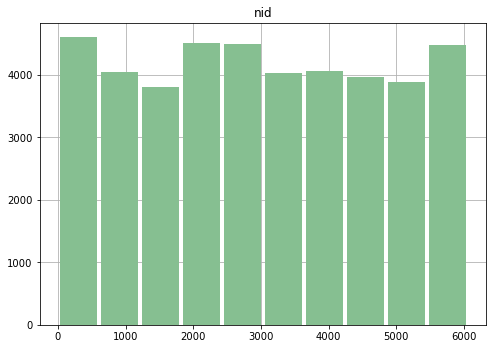

In [25]:
# Histogram
dataset.hist(column='nid', grid=True, figsize=(8,20), layout=(3,1), sharex=True, color='#86bf91', zorder=2, rwidth=0.9)

In [26]:
num_pid = len(dataset.pid.unique())
num_nid = len(dataset.nid.unique())
print('There are {} unique pid and {} unique nid in this dataset '.format(num_pid, num_nid))

There are 5485 unique pid and 5520 unique nid in this dataset 


In [27]:
pid_max = dataset.pid.max()
nid_max = dataset.nid.max()
print('There are {} distinct posts in posts-ctr and the max of pid is {}'.format(num_pid, pid_max))
print('There are {} distinct posts in posts-ctr and the max of nid is {}'.format(num_nid, nid_max))

There are 5485 distinct posts in posts-ctr and the max of pid is 6057
There are 5520 distinct posts in posts-ctr and the max of nid is 6057


##### Train Generalized Matrix Factorization and Test Model

##### define GMF model architeture and train routine

In [28]:
def get_GMF_model(num_pid, num_nid, latent_dim, vu_reg, vi_reg):
    """
    Build Generalized Matrix Factorization Model Topology
    
    Parameters
    ----------
    num_nid: int, total number of pid
    num_nid: int, total number of nid
    latent_dim: int, embedded dimension for pid vector and nid vector
    vu_reg: float, L2 regularization of user embedded layer
    vi_reg: float, L2 regularization of item embedded layer

    Return
    ------
    A Keras Model with GMF model architeture
    """
    # Input variables
    pid_input = Input(shape=(1,), dtype='int32', name='pib_input')
    nid_input = Input(shape=(1,), dtype='int32', name='nid_input')

    mf_embedding_pid = Embedding(
        input_dim = num_pid + 1,
        output_dim = latent_dim,
        embeddings_initializer = 'uniform',
        name = 'pid_embedding',
        embeddings_regularizer = l2(vu_reg),
        input_length = 1
    )
    
    mf_embedding_nid = Embedding(
        input_dim = num_nid + 1,
        output_dim = latent_dim,
        embeddings_initializer = 'uniform',
        name = 'nid_embedding',
        embeddings_regularizer = l2(vi_reg),
        input_length = 1
    ) 
    
    # Crucial to flatten an embedding vector!
    pid_latent = Flatten()(mf_embedding_pid(pid_input))
    nid_latent = Flatten()(mf_embedding_nid(nid_input))

    # Element-wise product of user and item embeddings 
    predict_vector = Multiply()([pid_latent, nid_latent])
    
    # Final prediction layer
    prediction = Dense(1, kernel_initializer='glorot_uniform', name='prediction')(predict_vector)
    
    # Stitch input and output
    model = Model([pid_input, nid_input], prediction)
    
    return model

def train_model(model, learner, batch_size, epochs, val_split, inputs, outputs, filepath):
    """
    define training routine, train models and save best model
    
    Parameters
    ----------
    model: a Keras model
    learner: str, one of ['sgd', 'adam', 'rmsprop', 'adagrad']
    batch_size: num samples per update
    epochs: num iterations
    val_split: split ratio for validation data
    inputs: inputs data
    outputs: outputs data
    """
    # add customized metric
    def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_true - y_pred)))
    
    # compile model
    model.compile(optimizer=learner, loss='mean_squared_error', metrics=['mean_squared_error', rmse])
    
    # add call backs
    early_stopper = EarlyStopping(monitor='val_rmse', patience=10, verbose=1)
    model_saver = ModelCheckpoint(filepath=filepath, monitor='val_rmse', save_best_only=True, save_weights_only=True)
    
    # train model
    history = model.fit(inputs, outputs, batch_size=batch_size, epochs=epochs, validation_split=val_split, callbacks=[early_stopper, model_saver])
    
    return history

def load_trained_model(model, weights_path):
    model.load_weights(weights_path)
    return model

##### Create GMF model

In [29]:
GMF_model = get_GMF_model(pid_max, nid_max, 10, 0, 0)
GMF_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
pib_input (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
nid_input (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
pid_embedding (Embedding)       (None, 1, 10)        60580       pib_input[0][0]                  
__________________________________________________________________________________________________
nid_embedding (Embedding)       (None, 1, 10)        60580       nid_input[0][0]                  
______________________________________________________________________________________________

In [30]:
from sklearn.preprocessing import StandardScaler

def df2xy(data):
    x = [data.pid.values, data.nid.values]

    scaler = StandardScaler()
    standardized = scaler.fit_transform(data.page_view.values.reshape(-1, 1))
    y = standardized.flatten()
    return x,y

train_data, valid_data = train_test_split(dataset, test_size=0.5, shuffle=True, random_state=99)
train_x, train_y = df2xy(train_data)
valid_x, valid_y = df2xy(valid_data)

##### Train GMF Model

In [31]:
# model config
BATCH_SIZE = 4096
EPOCHS = 10000
VAL_SPLIT = 0.1

# train model
history = train_model(
    GMF_model,
    tf.keras.optimizers.Adam(0.01),
    BATCH_SIZE,
    EPOCHS,
    VAL_SPLIT,
    inputs=train_x,
    outputs=train_y,
    filepath='model/neural-gmf-weights.hdf5')

Train on 18862 samples, validate on 2096 samples
Epoch 1/10000
18862/18862 [==============================] - 0s 24us/sample - loss: 0.6911 - mean_squared_error: 0.6911 - rmse: 0.7701 - val_loss: 3.7809 - val_mean_squared_error: 3.7809 - val_rmse: 1.9445
Epoch 2/10000
18862/18862 [==============================] - 0s 1us/sample - loss: 0.6901 - mean_squared_error: 0.6901 - rmse: 0.7730 - val_loss: 3.7810 - val_mean_squared_error: 3.7810 - val_rmse: 1.9445
Epoch 3/10000
18862/18862 [==============================] - 0s 1us/sample - loss: 0.6884 - mean_squared_error: 0.6884 - rmse: 0.7848 - val_loss: 3.7801 - val_mean_squared_error: 3.7801 - val_rmse: 1.9443
Epoch 4/10000
18862/18862 [==============================] - 0s 2us/sample - loss: 0.6852 - mean_squared_error: 0.6852 - rmse: 0.7482 - val_loss: 3.7790 - val_mean_squared_error: 3.7790 - val_rmse: 1.9440
Epoch 5/10000
18862/18862 [==============================] - 0s 2us/sample - loss: 0.6795 - mean_squared_error: 0.6795 - rmse: 0.7

In [32]:
def plot_learning_curve(history, metric):
    """
    Plot learning curve to compare training error vs. validation error
    """
    # get training error
    errors = history.history[metric]
    
    # get validation error
    val_errors = history.history['val_{}'.format(metric)]
    
    # get epochs
    epochs = range(1, len(errors) + 1)

    # plot
    plt.figure(figsize=(12, 7))
    plt.plot(epochs, errors, 'bo', label='training {}'.format(metric))
    plt.plot(epochs, val_errors, 'b', label='validation {}'.format(metric))
    plt.xlabel('number of epochs')
    plt.ylabel(metric)
    plt.title('Model Learning Curve')
    plt.grid(True)
    plt.legend()
    plt.show()

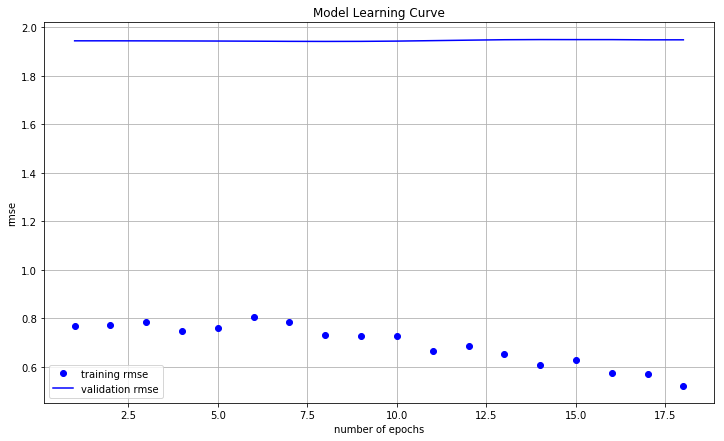

In [33]:
plot_learning_curve(history, 'rmse')

##### GMF Model Testing

In [38]:
# define rmse function
rmse = lambda true, pred: np.sqrt(np.mean(np.square(np.squeeze(predictions) - np.squeeze(valid_y))))

In [40]:
# load best model
GMF_model = get_GMF_model(pid_max, nid_max, 10, 0, 0)
GMF_model = load_trained_model(GMF_model, 'model/neural-gmf-weights.hdf5')

# make prediction using test data
predictions = GMF_model.predict(valid_x)

# get the RMSE
error = rmse(valid_y, predictions)
print('The out-of-sample RMSE of rating predictions is', round(error, 4))

The out-of-sample RMSE of rating predictions is 1.0038


#### Train Multi-Layer Perceptron Model and Test Model

##### define MLP model architeture

In [41]:
def get_MLP_model(num_pid, num_nid, layers, reg_layers):
    """
    Build Multi-Layer Perceptron Model Topology
    
    Parameters
    ----------
    num_users: int, total number of users
    num_iterms: int, total number of items
    layers: list of int, each element is the number of hidden units for each layer,
        with the exception of first element. First element is the sum of dims of
        user latent vector and item latent vector
    reg_layers: list of int, each element is the L2 regularization parameter for
        each layer in MLP

    Return
    ------
    A Keras Model with MLP model architeture
    """
    assert len(layers) == len(reg_layers)
    num_layer = len(layers) # Number of layers in the MLP
    
    # Input variables
    pid_input = Input(shape=(1,), dtype='int32', name='pid_input')
    nid_input = Input(shape=(1,), dtype='int32', name='nid_input')

    mlp_embedding_user = Embedding(
        input_dim=num_pid + 1,
        output_dim=layers[0] // 2,
        embeddings_initializer='uniform',
        name='user_embedding',
        embeddings_regularizer=l2(reg_layers[0]),
        input_length=1)
    
    mlp_embedding_item = Embedding(
        input_dim=num_nid + 1,
        output_dim=layers[0] // 2,
        embeddings_initializer='uniform',
        name='item_embedding',
        embeddings_regularizer=l2(reg_layers[0]),
        input_length=1) 
    
    # Crucial to flatten an embedding vector!
    pid_latent = Flatten()(mlp_embedding_user(pid_input))
    nid_latent = Flatten()(mlp_embedding_item(nid_input))

    # The 0-th layer is the concatenation of embedding layers
    vector = Concatenate(axis=-1)([pid_latent, nid_latent])

    # MLP layers
    for idx in range(1, num_layer):
        layer = Dense(
            units=layers[idx],
            activation='relu',
            kernel_initializer='glorot_uniform',
            kernel_regularizer=l2(reg_layers[idx]),
            name = 'layer%d' %idx)
        vector = layer(vector)
    
    # Final prediction layer
    prediction = Dense(1, kernel_initializer='glorot_uniform', name='prediction')(vector)
    
    # Stitch input and output
    model = Model([pid_input, nid_input], prediction)
    
    return model

##### Create MLP Model

In [43]:
MLP_model = get_MLP_model(pid_max, nid_max, [64, 32, 16, 8], [0, 0, 0, 0])
MLP_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
pid_input (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
nid_input (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 32)        193856      pid_input[0][0]                  
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 32)        193856      nid_input[0][0]                  
____________________________________________________________________________________________

##### Train MLP Model

In [44]:
# model config
BATCH_SIZE = 4096
EPOCHS = 10000
VAL_SPLIT = 0.1

# train model
history = train_model(
    MLP_model,
    tf.keras.optimizers.Adam(0.001),
    BATCH_SIZE,
    EPOCHS,
    VAL_SPLIT,
    inputs=train_x,
    outputs=train_y,
    filepath='model/neural-mlp-weights.hdf5')

Train on 18862 samples, validate on 2096 samples
Epoch 1/10000
18862/18862 [==============================] - 1s 28us/sample - loss: 0.6909 - mean_squared_error: 0.6909 - rmse: 0.8263 - val_loss: 3.7802 - val_mean_squared_error: 3.7802 - val_rmse: 1.9443
Epoch 2/10000
18862/18862 [==============================] - 0s 3us/sample - loss: 0.6876 - mean_squared_error: 0.6876 - rmse: 0.7995 - val_loss: 3.7787 - val_mean_squared_error: 3.7787 - val_rmse: 1.9439
Epoch 3/10000
18862/18862 [==============================] - 0s 3us/sample - loss: 0.6831 - mean_squared_error: 0.6831 - rmse: 0.7698 - val_loss: 3.7766 - val_mean_squared_error: 3.7766 - val_rmse: 1.9433
Epoch 4/10000
18862/18862 [==============================] - 0s 3us/sample - loss: 0.6776 - mean_squared_error: 0.6776 - rmse: 0.7889 - val_loss: 3.7739 - val_mean_squared_error: 3.7739 - val_rmse: 1.9427
Epoch 5/10000
18862/18862 [==============================] - 0s 3us/sample - loss: 0.6713 - mean_squared_error: 0.6713 - rmse: 0.7

##### MLP Learning Curve

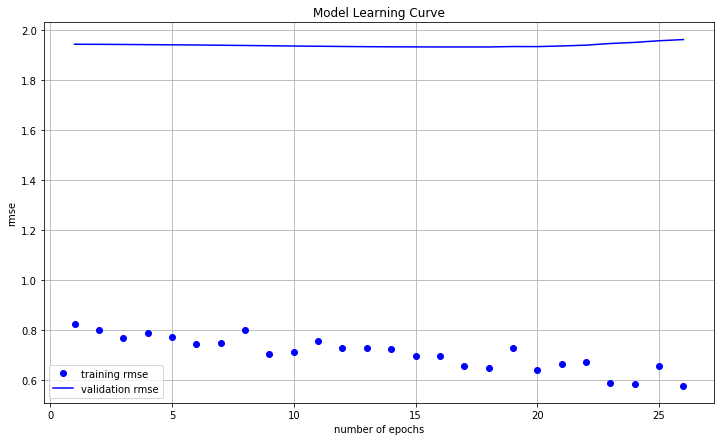

In [45]:
plot_learning_curve(history, 'rmse')

#### MLP Model Testing

##### And finally, make a prediction and check the testing error using out-of-sample data

In [46]:
# load best model
MLP_model = get_MLP_model(pid_max, nid_max, [64, 32, 16, 8], [0, 0, 0, 0])
MLP_model = load_trained_model(MLP_model, 'model/neural-mlp-weights.hdf5')

# make prediction using test data
predictions = MLP_model.predict(valid_x)

# get the RMSE
error = rmse(valid_y, predictions)

print('The out-of-sample RMSE of rating predictions is', round(error, 4))

The out-of-sample RMSE of rating predictions is 1.007


#### Train Neural Matrix Factorization (NeuralMF) and Test Model

##### define NeuralMF model architeture

In [47]:
def get_NeuralMF_model(num_pid, num_nid, MF_dim, MF_reg, MLP_layers, MLP_regs):
    """
    Build Neural Matrix Factorization (NeuralMF) Model Topology.
    This is stack version of both GMF and MLP
    
    Parameters
    ----------
    num_users: int, total number of users
    num_iterms: int, total number of items
    MF_dim: int, embedded dimension for user vector and item vector in MF
    MF_reg: tuple of float, L2 regularization of MF embedded layer
    MLP_layers: list of int, each element is the number of hidden units for each MLP layer,
        with the exception of first element. First element is the sum of dims of
        user latent vector and item latent vector
    MLP_regs: list of int, each element is the L2 regularization parameter for
        each layer in MLP

    Return
    ------
    A Keras Model with MLP model architeture
    """
    assert len(MLP_layers) == len(MLP_regs)
    num_MLP_layer = len(MLP_layers) # Number of layers in the MLP
    
    # Input variables
    pid_input = Input(shape=(1,), dtype='int32', name='pid_input')
    nid_input = Input(shape=(1,), dtype='int32', name='nid_input')

    # MF Embedding layer
    mf_embedding_pid = Embedding(
        input_dim=num_pid + 1,
        output_dim=MF_dim,
        embeddings_initializer='uniform',
        name='mf_user_embedding',
        embeddings_regularizer=l2(MF_reg[0]),
        input_length=1)
    
    mf_embedding_nid = Embedding(
        input_dim=num_nid + 1,
        output_dim=MF_dim,
        embeddings_initializer='uniform',
        name='mf_item_embedding',
        embeddings_regularizer=l2(MF_reg[1]),
        input_length=1)
    
    # MLP
    mlp_embedding_pid = Embedding(
        input_dim=num_pid + 1,
        output_dim=MLP_layers[0] // 2,
        embeddings_initializer='uniform',
        name='mlp_user_embedding',
        embeddings_regularizer=l2(MLP_regs[0]),
        input_length=1)
    
    mlp_embedding_nid = Embedding(
        input_dim=num_nid + 1,
        output_dim=MLP_layers[0] // 2,
        embeddings_initializer='uniform',
        name='mlp_item_embedding',
        embeddings_regularizer=l2(MLP_regs[0]),
        input_length=1) 
    
    # MF part
    mf_pid_latent = Flatten()(mf_embedding_pid(pid_input))
    mf_nid_latent = Flatten()(mf_embedding_nid(nid_input))
    mf_vector = Multiply()([mf_pid_latent, mf_nid_latent])

    # MLP part
    mlp_pid_latent = Flatten()(mlp_embedding_pid(pid_input))
    mlp_nid_latent = Flatten()(mlp_embedding_nid(nid_input))
    mlp_vector = Concatenate(axis=-1)([mlp_pid_latent, mlp_nid_latent])

    for idx in range(1, num_MLP_layer):
        layer = Dense(
            units=MLP_layers[idx],
            activation='relu',
            kernel_initializer='glorot_uniform',
            kernel_regularizer=l2(MLP_regs[idx]),
            name = 'layer%d' %idx)
        mlp_vector = layer(mlp_vector)
    
    # Concatenate MF and MLP parts
    predict_vector = Concatenate(axis=-1)([mf_vector, mlp_vector])

    # Final prediction layer
    prediction = Dense(1, kernel_initializer='glorot_uniform', name='prediction')(predict_vector)
    
    # Stitch input and output
    model = Model([pid_input, nid_input], prediction)
    
    return model

##### Create NeuralMF Model

In [48]:
NeuralMF_model = get_NeuralMF_model(
    num_pid=pid_max,
    num_nid=nid_max,
    MF_dim=10,
    MF_reg=(0, 0),
    MLP_layers=[64, 32, 16, 8],
    MLP_regs=[0, 0, 0, 0])
NeuralMF_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
pid_input (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
nid_input (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
mlp_user_embedding (Embedding)  (None, 1, 32)        193856      pid_input[0][0]                  
__________________________________________________________________________________________________
mlp_item_embedding (Embedding)  (None, 1, 32)        193856      nid_input[0][0]                  
____________________________________________________________________________________________

##### Train NeuralMF Model

In [49]:
# model config
BATCH_SIZE = 4096
EPOCHS = 100000
VAL_SPLIT = 0.1

# train model
history = train_model(
    NeuralMF_model,
    tf.keras.optimizers.Adam(0.01),
    BATCH_SIZE,
    EPOCHS,
    VAL_SPLIT,
    inputs=train_x,
    outputs=train_y,
    filepath='model/neural-nmf-weights.hdf5')

Train on 18862 samples, validate on 2096 samples
Epoch 1/100000
18862/18862 [==============================] - 1s 38us/sample - loss: 0.6906 - mean_squared_error: 0.6906 - rmse: 0.7702 - val_loss: 3.7614 - val_mean_squared_error: 3.7614 - val_rmse: 1.9394
Epoch 2/100000
18862/18862 [==============================] - 0s 3us/sample - loss: 0.6668 - mean_squared_error: 0.6668 - rmse: 0.7322 - val_loss: 3.7218 - val_mean_squared_error: 3.7218 - val_rmse: 1.9292
Epoch 3/100000
18862/18862 [==============================] - 0s 3us/sample - loss: 0.6193 - mean_squared_error: 0.6193 - rmse: 0.7316 - val_loss: 3.7039 - val_mean_squared_error: 3.7039 - val_rmse: 1.9246
Epoch 4/100000
18862/18862 [==============================] - 0s 2us/sample - loss: 0.5587 - mean_squared_error: 0.5587 - rmse: 0.7079 - val_loss: 3.7116 - val_mean_squared_error: 3.7116 - val_rmse: 1.9266
Epoch 5/100000
18862/18862 [==============================] - 0s 3us/sample - loss: 0.5025 - mean_squared_error: 0.5025 - rmse

##### Neural Matrix Factorization (NeuralMF) Learning Curve

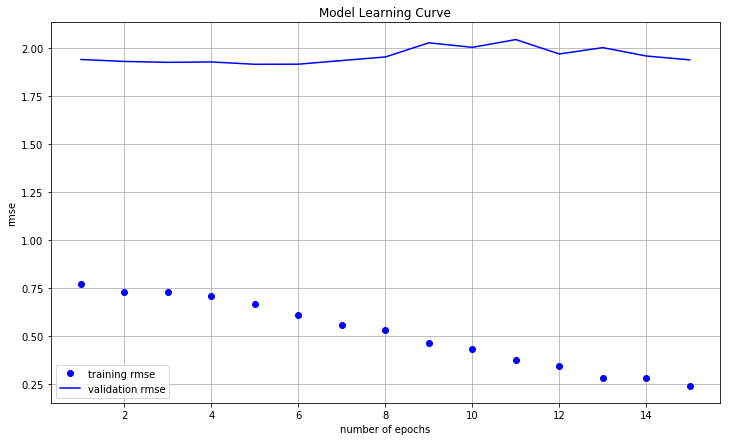

In [50]:
plot_learning_curve(history, 'rmse')

##### Neural Matrix Factorization (NeuralMF) Model Testing

##### And finally, make a prediction and check the testing error using out-of-sample data

In [51]:
# load best model
NeuralMF_model = get_NeuralMF_model(
    num_pid=pid_max,
    num_nid=nid_max,
    MF_dim=10,
    MF_reg=(0, 0),
    MLP_layers=[64, 32, 16, 8],
    MLP_regs=[0, 0, 0, 0])
NeuralMF_model = load_trained_model(NeuralMF_model, 'model/neural-nmf-weights.hdf5')

# make prediction using test data
predictions = NeuralMF_model.predict(valid_x)

# get the RMSE
error = rmse(valid_y, predictions)
print('The out-of-sample RMSE of rating predictions is', round(error, 4))

The out-of-sample RMSE of rating predictions is 1.0723


##### Recommendation

In [52]:
posts.sample(20)

,post_id,title,tags
5857,1775036,finasteride,"[31, 0, 0, 0, 0]"
3834,810343,Mengapa Masih Terjadi Kontraksi Rahim Setelah ...,"[3, 104, 24, 0, 0]"
3133,566180,Cara Mudah Atasi Sariawan di Tenggorokan yang ...,"[1, 119, 0, 0, 0]"
2080,226793,"Tanda-tanda Ejakulasi Wanita, Ini Faktanya","[2, 19, 18, 0, 0]"
705,16151,migrain tiap bangun tidur,"[40, 87, 0, 0, 0]"
1659,124735,Makanan Ini Identik dengan Kolesterol Jahat,"[1, 10, 39, 4, 0]"
1507,97349,Bisul,"[1, 5, 219, 0, 0]"
956,31962,Apa ini gejala angin duduk?,"[83, 214, 650, 0, 0]"
5172,1483452,Ketuban Pecah Dini,"[1, 5, 446, 0, 0]"
3726,771051,Mengetahui Penyebab dan Cara Tepat Mengatasi D...,"[1, 9, 8, 63, 209]"


##### See on Rating Data

In [53]:
post_id = 70980
dataset[dataset['post_id'] == post_id]

,post_id,pid,title,related_post_id,nid,related_title,related_tags,page_view


##### Find Similarity Based on Document to Vector

In [54]:
pid = post_id_pid[post_id]
sims = doc2vec_model.docvecs.most_similar([doc2vec_model[pid]], topn=20)
nids = [nid for nid,_ in sims]
most_similars = dataset[dataset['nid'].isin(nids)].drop_duplicates(subset='nid', keep='last')
most_similars[['related_post_id','nid','related_title','page_view']]

,related_post_id,nid,related_title,page_view
1701,201750,3929,Jenis dan Bentuk Kondom yang Keliru Bisa Gagal...,23
4339,557508,637,Variasi dan Bahaya Seks di Kamar Mandi,23
5927,17386,2128,"Fakta tentang Kondom Wanita, Jenis dan Cara Pe...",68
16293,11822,1452,Seks Oral yang Aman Seperti Apa?,23
19238,341622,2454,"Jangan Asal Pakai, Kenali Jenis Kondom dan Car...",23
27274,70980,1855,Jangan Sembarangan Memakai Sex Toys,23
27532,1200300,4529,Melakukan Hubungan Seks Sehat yang Berkualitas,23
27631,18090,4738,Hal yang Perlu Kamu Ketahui tentang Kondom dan...,23
29159,751353,594,Fakta Manfaat Ratus yang Perlu Anda Ketahui,23
32599,688206,710,Tips Memilih Pelembab untuk Kulit Kering,23


##### Scoring Based on Page Click Collaborative Filtering

In [55]:
# Creating dataset for making recommendations
nids = most_similars.nid.values
pred = [np.array([pid for i in range(len(nids))]), nids]
predictions = NeuralMF_model.predict(pred)
predictions = np.array([a[0] for a in predictions])
recommended_ids = (-predictions).argsort()[:20]

recommendations = pd.DataFrame()
nids = [nids[idx] for idx in recommended_ids]
for nid in nids:
    recommendations = recommendations.append(dataset[dataset['nid'] == nid])
recommendations[['related_post_id','nid','related_title','page_view']].drop_duplicates(subset='nid', keep='last')

,related_post_id,nid,related_title,page_view
40211,528397,682,Cara Memuaskan Pasangan Ini Perlu Anda Coba,23
5927,17386,2128,"Fakta tentang Kondom Wanita, Jenis dan Cara Pe...",68
19238,341622,2454,"Jangan Asal Pakai, Kenali Jenis Kondom dan Car...",23
32599,688206,710,Tips Memilih Pelembab untuk Kulit Kering,23
27532,1200300,4529,Melakukan Hubungan Seks Sehat yang Berkualitas,23
39648,357363,5697,Berisiko Terkena Penyakit Kelamin Akibat Seks ...,23
38840,1745547,579,Cara Merawat Wajah dengan Sabun untuk Kulit Se...,23
27274,70980,1855,Jangan Sembarangan Memakai Sex Toys,23
29159,751353,594,Fakta Manfaat Ratus yang Perlu Anda Ketahui,23
32792,14228,2087,Cara Mencuci Sayur dan Buah yang Benar Agar Te...,23
